## Script to split annotated data into cycles and label these

In [29]:
# libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # Gaussian smoothing
from scipy.signal import argrelextrema  # Local minima detection
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path
import glob
import os

### Functions needed

In [30]:
# Function to load JSON data
def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)
    
# Function to compute keypoints relative to the hip position
def compute_relative_keypoints(keypoints):
    """Compute keypoints relative to the hip keypoint."""
    hip_x, hip_y, hip_v = keypoints[hip_index * 3 : hip_index * 3 + 3]
    
    if hip_v == 0:
        return [(None, None)] * (len(keypoints) // 3)

    relative_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, v = keypoints[i:i+3]
        if v > 0:
            rel_x = x - hip_x
            rel_y = y - hip_y
        else:
            rel_x = rel_y = None
        relative_keypoints.append((rel_x, rel_y))
    
    return relative_keypoints

# Function to process data from a dataset
def process_data(data):
    frames = sorted(set(anno["image_id"] for anno in data.get("annotations", [])))
    keypoint_movements = {"x": [], "y": []}  # Store only LAnkle movement

    for annotation in data.get("annotations", []):
        keypoints = annotation["keypoints"]
        relative_keypoints = compute_relative_keypoints(keypoints)

        # Store only Left Ankle (LAnkle) movements
        lankle_x, lankle_y = relative_keypoints[lankle_index]
        keypoint_movements["x"].append(lankle_x)
        keypoint_movements["y"].append(lankle_y)

    return frames, keypoint_movements

# Function to normalize signals using Z-score normalization
def normalize_signal(signal):
    """Normalize the signal using Z-score normalization."""
    signal = np.array(signal, dtype=np.float32)
    valid_values = signal[~np.isnan(signal)]

    if len(valid_values) > 1:
        mean = np.mean(valid_values)
        std = np.std(valid_values)
        signal = (signal - mean) / std if std > 0 else signal - mean
    return signal

# Function to apply Gaussian smoothing
def smooth_signal(signal, sigma=2):
    """Apply Gaussian low-pass filter to smooth the signal."""
    return gaussian_filter1d(signal, sigma=sigma, mode="nearest")  

# Function to create a dynamic plot for the X values
def create_x_plot(frames, x_values, current_frame):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
    ax.plot(frames[:current_frame + 1], x_values[:current_frame + 1], color='red', label='LAnkle X')
    ax.set_xlim([frames[0], frames[-1]])
    ax.set_ylim(min(x_values) - 1, max(x_values) + 1)
    ax.set_xlabel("Frame")
    ax.set_ylabel("X Position")
    ax.legend(loc="upper left")

    canvas = FigureCanvas(fig)
    canvas.draw()
    plot_image = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return plot_image

# Function to save cycles with labels to a JSON file
def save_cycle_to_json(cycle_data, video_id):
    
    filename = "labeled_cycles"+video_id+".json"
    
    try:
        with open(filename, "r") as file:
            existing_data = json.load(file)
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = {}

    cycle_id = f"Cycle {len(existing_data) + 1}"  # Auto-increment cycle ID
    cycle_data[f"{CHOOSEN_JOINT}_{CHOOSEN_DIM}"] = list(map(float, cycle_data[f"{CHOOSEN_JOINT}_{CHOOSEN_DIM}"]))  # Convert NumPy floats to Python floats
    existing_data[cycle_id] = cycle_data

    with open(filename, "w") as file:
        json.dump(existing_data, file, indent=4)
    
    print(f"Cycle saved as {cycle_id}")


# Function to play video and overlay the X value plot, pausing at local minima
def play_video_with_x_plot(video_path, frames, x_values_raw, x_values_smoothed, min_indices, frame_rate=30):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    current_min_index = 0  # Track local minima

    while current_min_index < len(min_indices) - 1:  # Ensure at least two minima
        start_frame = frames[min_indices[current_min_index]]
        end_frame = frames[min_indices[current_min_index + 1]]
        cycle_x_values = x_values_raw[min_indices[current_min_index] : min_indices[current_min_index + 1] + 1]

        while True:  # Keep looping until user chooses to proceed
            for current_frame in range(start_frame, end_frame + 1):
                cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
                ret, frame = cap.read()
                if not ret:
                    print(f"Error: Could not read frame {current_frame}.")
                    break

                plot_image = create_x_plot(frames, x_values_smoothed, current_frame)
                plot_height, plot_width = plot_image.shape[:2]
                frame_height, frame_width = frame.shape[:2]
                plot_resized = cv2.resize(plot_image, (frame_width // 3, plot_height * (frame_width // 3) // plot_width))

                roi = frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:]
                overlayed_frame = cv2.addWeighted(roi, 0.2, plot_resized, 1, 0)
                frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:] = overlayed_frame

                cv2.imshow("Video with X Plot", frame)
                cv2.waitKey(1000 // frame_rate)

            # Ask the user whether to label, replay, or quit
            print("Options: [g2], [g3], [unknown], [R]eplay cycle, [Q]uit")
            user_input = input("Options: [L]abel cycle, [R]eplay cycle, [Q]uit. Enter your choice: ").strip().lower()

            if user_input in LABELS:
                cycle_data = {
                    f"{CHOOSEN_JOINT}_{CHOOSEN_DIM}": list(map(float, cycle_x_values)),
                    "Label": user_input
                }
                save_cycle_to_json(cycle_data, video_id)
                current_min_index += 1
                break  # Exit loop to proceed to the next cycle

            elif user_input == 'r':  # Replay the same cycle
                print("Replaying cycle...")
                continue  # Restart the loop to replay

            elif user_input == 'q':  # Quit
                cap.release()
                cv2.destroyAllWindows()
                return


    cap.release()
    cv2.destroyAllWindows()


### Config

In [31]:
CHOOSEN_JOINT = "RAnkle"
CHOOSEN_DIM = "x"
sigma_value = 2  # Adjust smoothing strength
order = 22 # How sensetive to find local minima
LABELS = ["g2", "g3", "g4", "unknown"]

### Paths for videos and annotated data

In [32]:
VIDEO_DIR = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData")
ANNO_DIR = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\Annotations")
video_id = "38" # 15_cut, 17_cut, 18_cut, 22_cut, 38
file_path = os.path.join(ANNO_DIR, video_id + ".json")

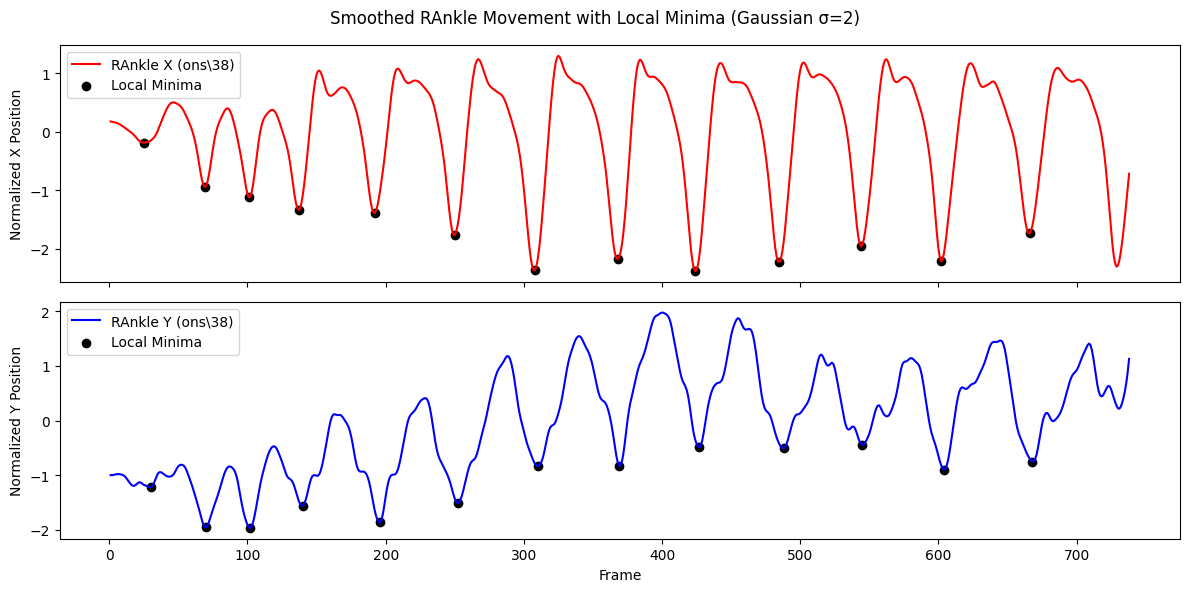

: 

In [ ]:
# Load JSON data
dataset = load_json(file_path)

# Extract keypoint labels (assumes same structure across files)
keypoint_labels = dataset["categories"][0]["keypoints"]
hip_index = keypoint_labels.index("Hip")  # Find the index of the "Hip" keypoint
lankle_index = keypoint_labels.index(CHOOSEN_JOINT)  # Find index for joint we choose

# Process dataset, get keypoints and frames
frames, keypoints = process_data(dataset)

# Normalize and smooth all datasets
smoothed_normalized_keypoints = {"x": [], "y": []}
smoothed_normalized_keypoints["x"] = normalize_signal(keypoints["x"])
smoothed_normalized_keypoints["y"] = normalize_signal(keypoints["y"])

smoothed_normalized_keypoints["x"] = smooth_signal(smoothed_normalized_keypoints["x"], sigma=sigma_value)
smoothed_normalized_keypoints["y"] = smooth_signal(smoothed_normalized_keypoints["y"], sigma=sigma_value)

# Plot Joint movement (X and Y in separate plots)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Detect local minima for X movement
x_values = np.array(smoothed_normalized_keypoints["x"])
x_min_indices = argrelextrema(x_values, np.less, order=order)[0]  

# Detect local minima for Y movement
y_values = np.array(smoothed_normalized_keypoints["y"])
y_min_indices = argrelextrema(y_values, np.less, order=order)[0]  

# Plot choosen joint X movement
axs[0].plot(frames, x_values, label=f"{CHOOSEN_JOINT} X ({file_path[-11:-5]})", color="red")
axs[0].scatter(np.array(frames)[x_min_indices], x_values[x_min_indices], color="black", marker="o", label="Local Minima")
axs[0].set_ylabel("Normalized X Position")
axs[0].legend()

# Plot choosen joint Y movement
axs[1].plot(frames, y_values, label=f"{CHOOSEN_JOINT} Y ({file_path[-11:-5]})", color="blue")
axs[1].scatter(np.array(frames)[y_min_indices], y_values[y_min_indices], color="black", marker="o", label="Local Minima")
axs[1].set_ylabel("Normalized Y Position")
axs[1].set_xlabel("Frame")
axs[1].legend()

plt.suptitle(f"Smoothed {CHOOSEN_JOINT} Movement with Local Minima (Gaussian σ={sigma_value})")
plt.tight_layout()
plt.show()

In [ ]:
# Get the corresponding X values for each frame
x_values = [keypoints[CHOOSEN_DIM][i] for i in range(len(frames))]
x_values_smoothed = [smoothed_normalized_keypoints[CHOOSEN_DIM][i] for i in range(len(frames))]

# Video path
video_path = os.path.join(VIDEO_DIR, "DJI_00" + video_id + ".mp4")

if CHOOSEN_DIM == "x":
    min_indices = x_min_indices
else:
    min_indices = y_min_indices
    
# Run the function
play_video_with_x_plot(video_path, frames, x_values, x_values_smoothed, min_indices, frame_rate=30)

Options: [L]abel cycle, [R]eplay cycle, [Q]uit
Cycle saved as Cycle 1
Options: [L]abel cycle, [R]eplay cycle, [Q]uit
Replaying cycle...
Options: [L]abel cycle, [R]eplay cycle, [Q]uit
Cycle saved as Cycle 2
Options: [L]abel cycle, [R]eplay cycle, [Q]uit
Cycle saved as Cycle 3
Options: [L]abel cycle, [R]eplay cycle, [Q]uit
Cycle saved as Cycle 4
Options: [L]abel cycle, [R]eplay cycle, [Q]uit
Cycle saved as Cycle 5
Options: [L]abel cycle, [R]eplay cycle, [Q]uit
Cycle saved as Cycle 6
Options: [L]abel cycle, [R]eplay cycle, [Q]uit
